In [17]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.7.2 anndata==0.7.8 umap==0.5.3 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6


In [3]:
path = "/home/unix/sjohri/valab_sjohri/projects/github_code/beanie-analysis/"

In [4]:
adata1 = sc.read_10x_h5(path+"/data/brca/bassez_2021/1863-counts_cells_cohort1.h5")
adata1.obs = pd.read_csv(path+"/data/brca/bassez_2021/raw_data/1872-BIOKEY_metaData_cohort1_web.csv", index_col=0)
adata1

reading /home/unix/sjohri/valab_sjohri/projects/github_code/beanie-analysis//data/brca/bassez_2021/1863-counts_cells_cohort1.h5
 (0:00:15)


AnnData object with n_obs × n_vars = 175942 × 25288
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'timepoint', 'expansion', 'BC_type', 'cellType', 'cohort'
    var: 'gene_ids'

In [5]:
# Subset cancer cells and ER+ tumors 
adata_concat = adata1[(adata1.obs.cellType=="Cancer_cell") & (adata1.obs.BC_type=="ER+")]
adata_concat

View of AnnData object with n_obs × n_vars = 27118 × 25288
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'timepoint', 'expansion', 'BC_type', 'cellType', 'cohort'
    var: 'gene_ids'

In [6]:
# generate metad columns
adata_concat.obs["group_id"] = "NA"
adata_concat.obs.group_id = adata_concat.obs.timepoint.map({"Pre":"treatment_naive","On":"anti_PD1"})
adata_concat.obs["sample_id"] = "NA"
adata_concat.obs.sample_id = adata_concat.obs.patient_id + "_" + "ER" + "_" + adata_concat.obs.group_id
adata_concat

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 27118 × 25288
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'timepoint', 'expansion', 'BC_type', 'cellType', 'cohort', 'group_id', 'sample_id'
    var: 'gene_ids'

In [7]:
adata_concat.obs.group_id.value_counts()

treatment_naive    15210
anti_PD1           11908
Name: group_id, dtype: int64

In [8]:
adata_concat.obs.sample_id.value_counts()

BIOKEY_21_ER_anti_PD1           3580
BIOKEY_30_ER_treatment_naive    3267
BIOKEY_6_ER_treatment_naive     2912
BIOKEY_30_ER_anti_PD1           2383
BIOKEY_17_ER_treatment_naive    1915
BIOKEY_12_ER_treatment_naive    1425
BIOKEY_17_ER_anti_PD1           1343
BIOKEY_21_ER_treatment_naive    1318
BIOKEY_24_ER_anti_PD1           1085
BIOKEY_24_ER_treatment_naive     887
BIOKEY_4_ER_treatment_naive      847
BIOKEY_7_ER_treatment_naive      561
BIOKEY_3_ER_anti_PD1             540
BIOKEY_7_ER_anti_PD1             525
BIOKEY_4_ER_anti_PD1             458
BIOKEY_3_ER_treatment_naive      437
BIOKEY_6_ER_anti_PD1             424
BIOKEY_27_ER_treatment_naive     408
BIOKEY_20_ER_anti_PD1            386
BIOKEY_29_ER_treatment_naive     348
BIOKEY_18_ER_anti_PD1            330
BIOKEY_12_ER_anti_PD1            295
BIOKEY_22_ER_anti_PD1            286
BIOKEY_22_ER_treatment_naive     270
BIOKEY_18_ER_treatment_naive     212
BIOKEY_5_ER_treatment_naive      209
BIOKEY_20_ER_treatment_naive     194
B

In [9]:
#Normalize gene counts
sc.pp.normalize_total(adata_concat, target_sum=1e6)

# Logarithmize the data.
sc.pp.log1p(adata_concat)

#Store raw data, for finding markers in each cluster and other analysis
adata_concat.raw = adata_concat

normalizing counts per cell
    finished (0:00:00)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


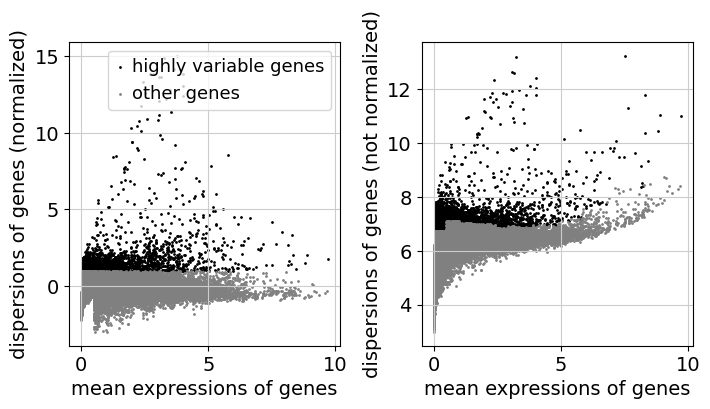

Highly variable genes: 3000


In [10]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata_concat, n_top_genes=3000)
sc.pl.highly_variable_genes(adata_concat)

print("Highly variable genes: %d"%sum(adata_concat.var.highly_variable))
var_genes_all = adata_concat.var.highly_variable
adata_concat = adata_concat[:,var_genes_all]

In [11]:
sc.pp.scale(adata_concat, max_value=10)

/home/unix/sjohri/valab_sjohri/envs/beanie_revisions/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:21)


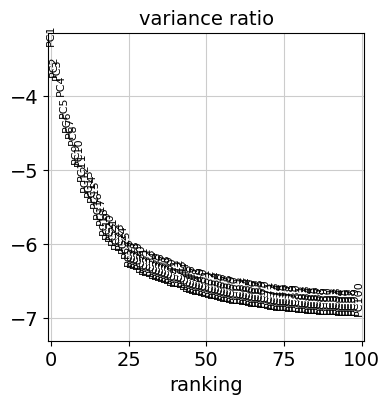

In [12]:
# Set seed
import random
initialization = 3120
random.seed(initialization)

sc.pp.pca(adata_concat, random_state=initialization, svd_solver='arpack', n_comps=100)
sc.pl.pca_variance_ratio(adata_concat, n_pcs= 100, log=True, show = True)
# sc.pl.pca_overview(adata_concat,color="n_genes")

In [13]:
sc.external.pp.harmony_integrate(adata_concat, key=["sample_id"],
                                 random_state=initialization, max_iter_harmony=50)
adata_concat.obsm['X_pca'] = adata_concat.obsm['X_pca_harmony']

2024-11-13 15:12:18,392 - harmonypy - INFO - Iteration 1 of 50
2024-11-13 15:12:36,360 - harmonypy - INFO - Iteration 2 of 50
2024-11-13 15:12:53,522 - harmonypy - INFO - Converged after 2 iterations


In [14]:
npc = 100
sc.pp.neighbors(adata_concat, random_state=initialization, n_neighbors=500, n_pcs=npc)
sc.tl.leiden(adata_concat, random_state=initialization, resolution=0.1)
sc.tl.umap(adata_concat, random_state=initialization, min_dist=0.2)

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:20:25)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:12)


... storing 'patient_id' as categorical
... storing 'timepoint' as categorical
... storing 'expansion' as categorical
... storing 'BC_type' as categorical
... storing 'cellType' as categorical
... storing 'cohort' as categorical
... storing 'group_id' as categorical
... storing 'sample_id' as categorical


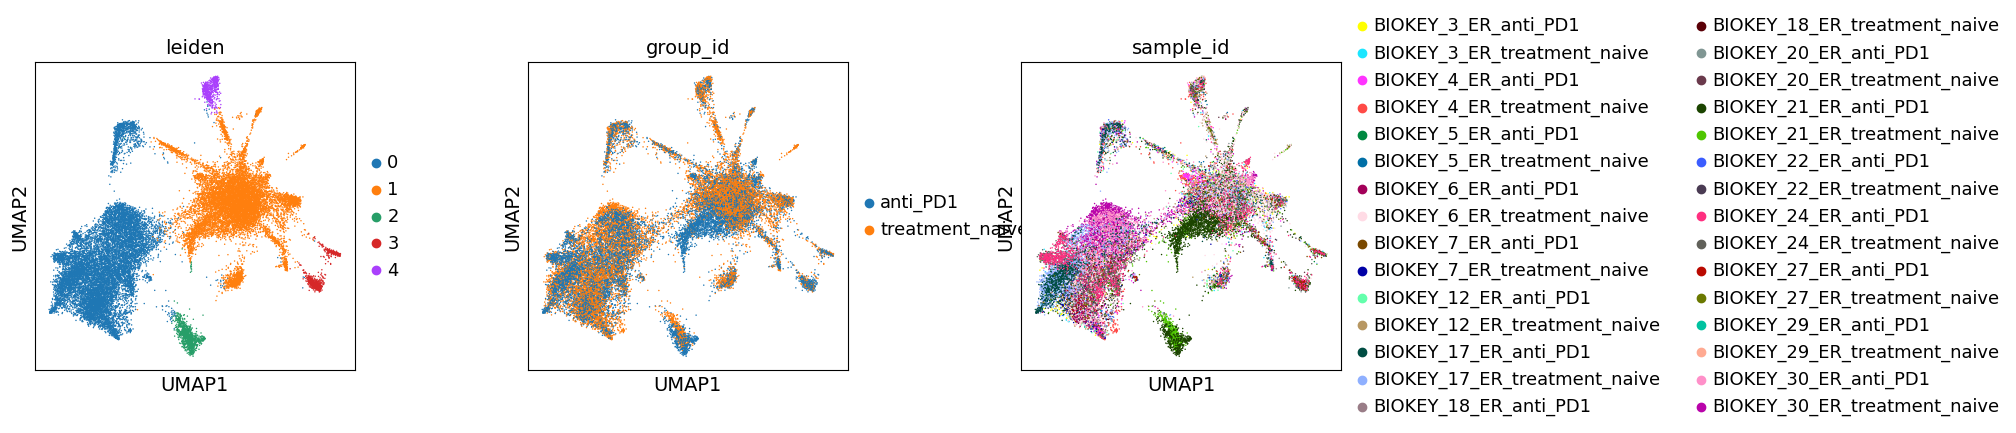

In [15]:
sc.pl.umap(adata_concat, color=['leiden', 'group_id', 'sample_id'], wspace=0.4, show = True)

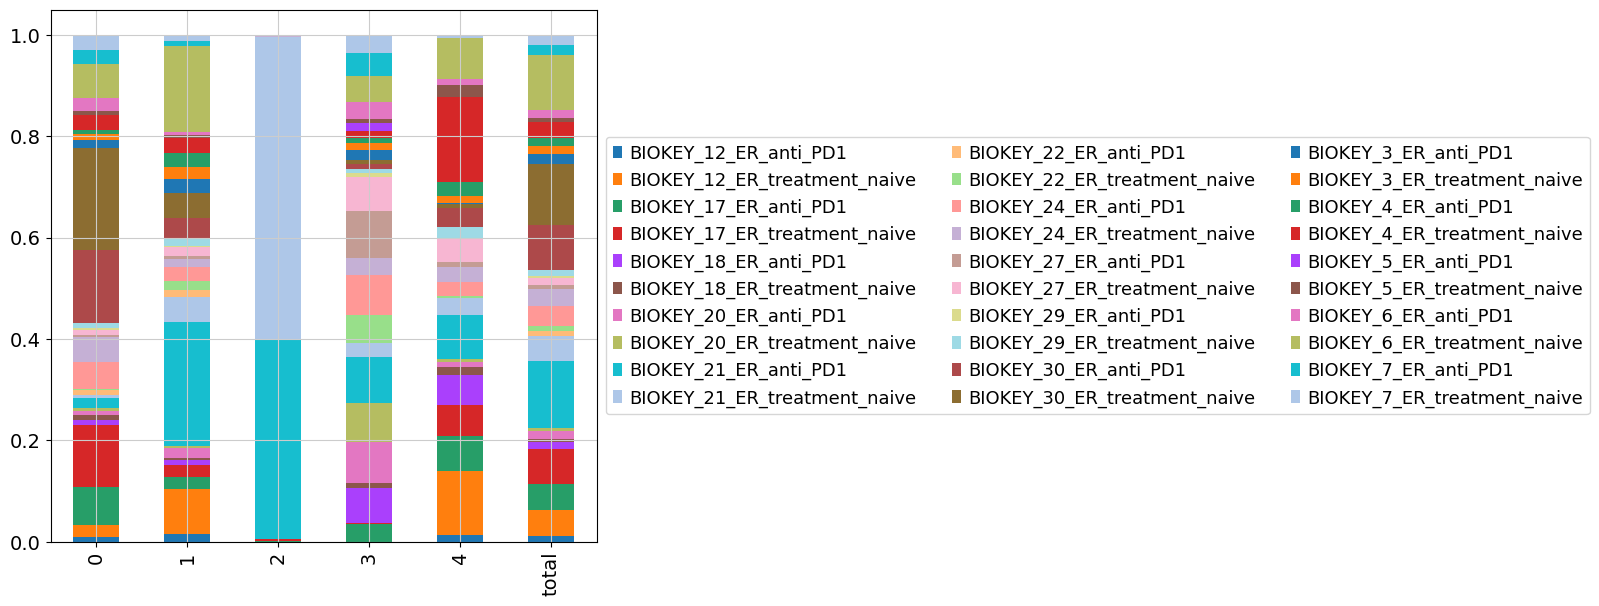

In [18]:
leiden_prop = dict()
no_clusters = len(adata_concat.obs['leiden'].unique())
for sn in adata_concat.obs['sample_id'].unique():
    temp = adata_concat[adata_concat.obs['sample_id'] == sn,:]
    cell_count = temp.obs['leiden'].value_counts()
    cell_count = cell_count.sort_index()
    cell_count = cell_count.to_dict()
    cell_count = [cell_count[str(x)] if str(x) in cell_count.keys() else 0 for x in range(0,no_clusters)]
    leiden_prop[sn] = cell_count
    
leiden_prop = pd.DataFrame(leiden_prop).T

leiden_prop['total'] = leiden_prop.sum(axis = 1)
leiden_prct = pd.DataFrame()
for x in leiden_prop.columns:
    leiden_prct[x] = leiden_prop[x]/leiden_prop[x].sum()
leiden_prct = leiden_prct.sort_index()

leiden_prct.T.plot.bar(stacked=True, legend = False,figsize=(7,7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol = 3)

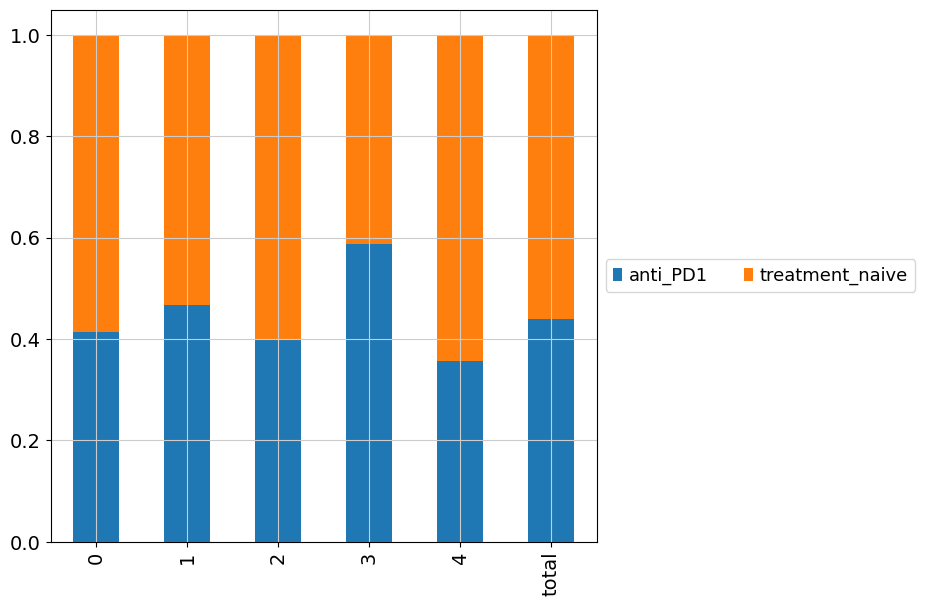

In [19]:
leiden_prop = dict()
no_clusters = len(adata_concat.obs['leiden'].unique())
for sn in adata_concat.obs['group_id'].unique():
    temp = adata_concat[adata_concat.obs['group_id'] == sn,:]
    cell_count = temp.obs['leiden'].value_counts()
    cell_count = cell_count.sort_index()
    cell_count = cell_count.to_dict()
    cell_count = [cell_count[str(x)] if str(x) in cell_count.keys() else 0 for x in range(0,no_clusters)]
    leiden_prop[sn] = cell_count
    
leiden_prop = pd.DataFrame(leiden_prop).T

leiden_prop['total'] = leiden_prop.sum(axis = 1)
leiden_prct = pd.DataFrame()
for x in leiden_prop.columns:
    leiden_prct[x] = leiden_prop[x]/leiden_prop[x].sum()
leiden_prct = leiden_prct.sort_index()

leiden_prct.T.plot.bar(stacked=True, legend = False,figsize=(7,7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol = 3)

In [20]:
sc.tl.rank_genes_groups(adata_concat, 'leiden', method='wilcoxon', corr_method="benjamini-hochberg")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:01)


In [21]:
adata_concat.write_h5ad("./inputs/analysis_1/adata_full.h5ad")

In [24]:
dmap_brca = pkl.load(open("brca_sampleid_map.pkl","rb"))
adata_concat.obs.sample_id = adata_concat.obs.sample_id.map(dmap_brca)

cluster_ids = sorted(set(adata_concat.obs.leiden))
for idx in cluster_ids:
    # save non log-normalized counts (set normalized=False in BEANIE)
    adata1[adata_concat[adata_concat.obs.leiden==idx].obs.index,].write_h5ad(f"./inputs/analysis_1/ts{int(idx)+1}_adata.h5ad")
    adata_concat[adata_concat.obs.leiden==idx].obs[["sample_id","group_id"]].to_csv(f"./inputs/analysis_1/ts{int(idx)+1}_metad.csv")

/home/unix/sjohri/valab_sjohri/envs/beanie_revisions/lib/python3.6/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'patient_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'expansion' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'BC_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cellType' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cohort' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'patient_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'expans